In [1]:
import sys
sys.path.append("../Modules/")
sys.path.append("../pyFiles/")
sys.path.append("../")
import os

import pandas as pd
import numpy as np

# from configobj import ConfigObj
# from configobj import flatten_errors
# from validate import Validator
    
import logging

# from analysisParameters import loadParameters
# from loadDataE1 import loadSessionDict

#fmt = 'logging.Formatter(''%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
fmt = '%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
logging.basicConfig(level=logging.INFO, format=fmt)
logger = logging.getLogger(__name__)



In [2]:
# sessionDict = projectTrajectories(sessionDict)
import matplotlib.pyplot as plt
%matplotlib notebook

### Save all out automoatically

In [3]:
import pickle

file = open('../sessionFiles.pickle', 'rb')
allSessions = pickle.load(file)
file.close()

In [4]:
# subData = gbSub.get_group(0)
# subData

sessionDict = allSessions[0]



In [5]:
# (p,ax) = plotProjectedTrajectory(trData,trInfo)

def plotProjectedTrajectory(trData,trInfo):

    from processData import gazeAnalysisWindow

    halfHFOVDegs = 80
    winSizeMS = 20
    polyorder = 3
    interpResS = .001

    ####

    initTTC = float(trInfo['ballInitialPos','z']) / -float(trInfo['ballInitialVel','z'])

    # Analysis should focus on the frames before ball collision or passing
    
    trialTime_fr = np.array(trData['frameTime'],np.float64) - np.array(trData['frameTime'],np.float64)[0]
    endFrameIdx = np.where( trialTime_fr > initTTC )[0][0]
    lastTrajFrame = np.min([int(endFrameIdx),
                int(trInfo[('passVertPlaneAtPaddleFr', '')])])
    plotTime_fr = np.array(trData['frameTime'],np.float64)[:lastTrajFrame] - np.array(trData['frameTime'],np.float64)[0]


    winStartTimeMs = sessionDict['analysisParameters']['analysisWindowStart']
    winEndTimeMs = sessionDict['analysisParameters']['analysisWindowEnd']

    # intepolate ball and gaze Az / El

    interpTime_s = np.arange(0,trialTime_fr[-1],interpResS)
    interpBallAz_s = np.interp(interpTime_s,plotTime_fr,np.array(trData['ball_az'][:lastTrajFrame],dtype=np.float64))
    interpBallEl_s = np.interp(interpTime_s,plotTime_fr,np.array(trData['ball_el'][:lastTrajFrame],dtype=np.float64))
    
    interpGazeAz_s = np.interp(interpTime_s,plotTime_fr,np.array(trData['cycGIW_az'][:lastTrajFrame],dtype=np.float64))
    interpGazeEl_s = np.interp(interpTime_s,plotTime_fr,np.array(trData['cycGIW_el'][:lastTrajFrame],dtype=np.float64))

    ####

    ballWinEnd_AzEl = trInfo['ballWinEnd_AzEl'].values[0]
    ballAtWinEndVelPred_AzEl = trInfo['ballAtWinEndVelPred_AzEl'].values[0]  

    gazeMinDistLoc_AzEl = np.array(trInfo['gazeMinDistLoc_AzEl'].values[0],dtype=np.float64)
    normLocInWindow = np.float64(trInfo['normLocInWindow'])

    # Win start/end relative to original time to arrival/contact
    winStartSampleIdx = np.where( interpTime_s > initTTC + winStartTimeMs/1000.0 )[0][0]
    winEndSampleIdx = np.where( interpTime_s > initTTC + winEndTimeMs/1000.0 )[0][0]
    windowFr = np.arange(winStartSampleIdx,winEndSampleIdx)

    # Stop analyzing gaze behavior at either the time of the catch or time to arrive
    endSampleIdx = np.where( interpTime_s > initTTC )[0][0]
    passingTime = trialTime_fr[int(trInfo[('passVertPlaneAtPaddleFr', '')])]
    passingSampleIdx = np.where( interpTime_s > passingTime)[0][0]

    if( passingSampleIdx < endSampleIdx):  
        endSampleIdx = passingSampleIdx

    ############

    halfVFOVDegs = halfHFOVDegs / 1.77

    p, ax = plt.subplots(1, 1,figsize=(8,8)) #sharey=True)
    cList = ['r','g','b']
    lineHandles = []

    ballH = ax.plot(interpBallAz_s[:endSampleIdx],interpBallEl_s[:endSampleIdx],color='b',linewidth=3,alpha = 0.4)
    gazeH = ax.plot(interpGazeAz_s[:endSampleIdx],interpGazeEl_s[:endSampleIdx],color='r',linewidth=3,alpha = 0.4)

    from matplotlib import patches as pt


    balllRadiusVel = trInfo['balllRadiusVel']    
    ballRadiusWinEnd = trInfo['ballRadiusWinEnd']    


    ax.add_patch(pt.Circle(ballWinEnd_AzEl,radius=ballRadiusWinEnd,
                    fill=False,facecolor=None,ec='k',lw=3))

    ax.plot(interpBallAz_s[windowFr],interpBallEl_s[windowFr],color='b',linewidth=5, alpha = 0.6)
    ax.plot(interpGazeAz_s[windowFr],interpGazeEl_s[windowFr],color='r',linewidth=5,alpha = 0.6)


    for i in np.arange(0,len(windowFr),5):
        pf = windowFr[i]
        xs = [interpBallAz_s[pf], interpGazeAz_s[pf]]
        ys = [interpBallEl_s[pf], interpGazeEl_s[pf]]
        ax.plot(xs,ys,color='k',linewidth=1,alpha = 0.3)



    ax.axis('equal')
    ax.axes.spines['top'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)
    ax.axes.yaxis.grid(True)
    ax.axes.xaxis.grid(True)
    p.set_facecolor('w')

    plt.xlim([-30,30])
    plt.ylim([-15,35])

    observedH = ax.scatter(ballWinEnd_AzEl[0],ballWinEnd_AzEl[1],c='k',s=150,marker='8')
    constantVelH = ax.scatter(ballAtWinEndVelPred_AzEl[0],ballAtWinEndVelPred_AzEl[1],c='k',s=150,marker='v')
    gazeLoc = ax.scatter(gazeMinDistLoc_AzEl[0],gazeMinDistLoc_AzEl[1],c='m',s=150,marker='x',lw=6)


    ax.text(.01,.01,str('NormLoc: {0:.2f}').format(normLocInWindow),transform=ax.transAxes)
#     ax.text(.01,.03,str('Expansion gain: {}').format(float(trInfo['expansionGain'])),transform=ax.transAxes)


    ax.legend([gazeLoc,
                constantVelH,
                observedH], 

                ['point nearest to gaze',
                'constant speed model',
                'actual displacement'])
    
    

In [6]:
list(sessionDict['trialInfo'].groupby(['blockNumber','trialNumber']) .groups)

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (3, 19),
 (3, 20),
 (3, 21)]

CWD:/Users/gjdpci/Documents/GitHub/Interception_UXF_Analysis/Analysis Notebooks


<IPython.core.display.Javascript object>


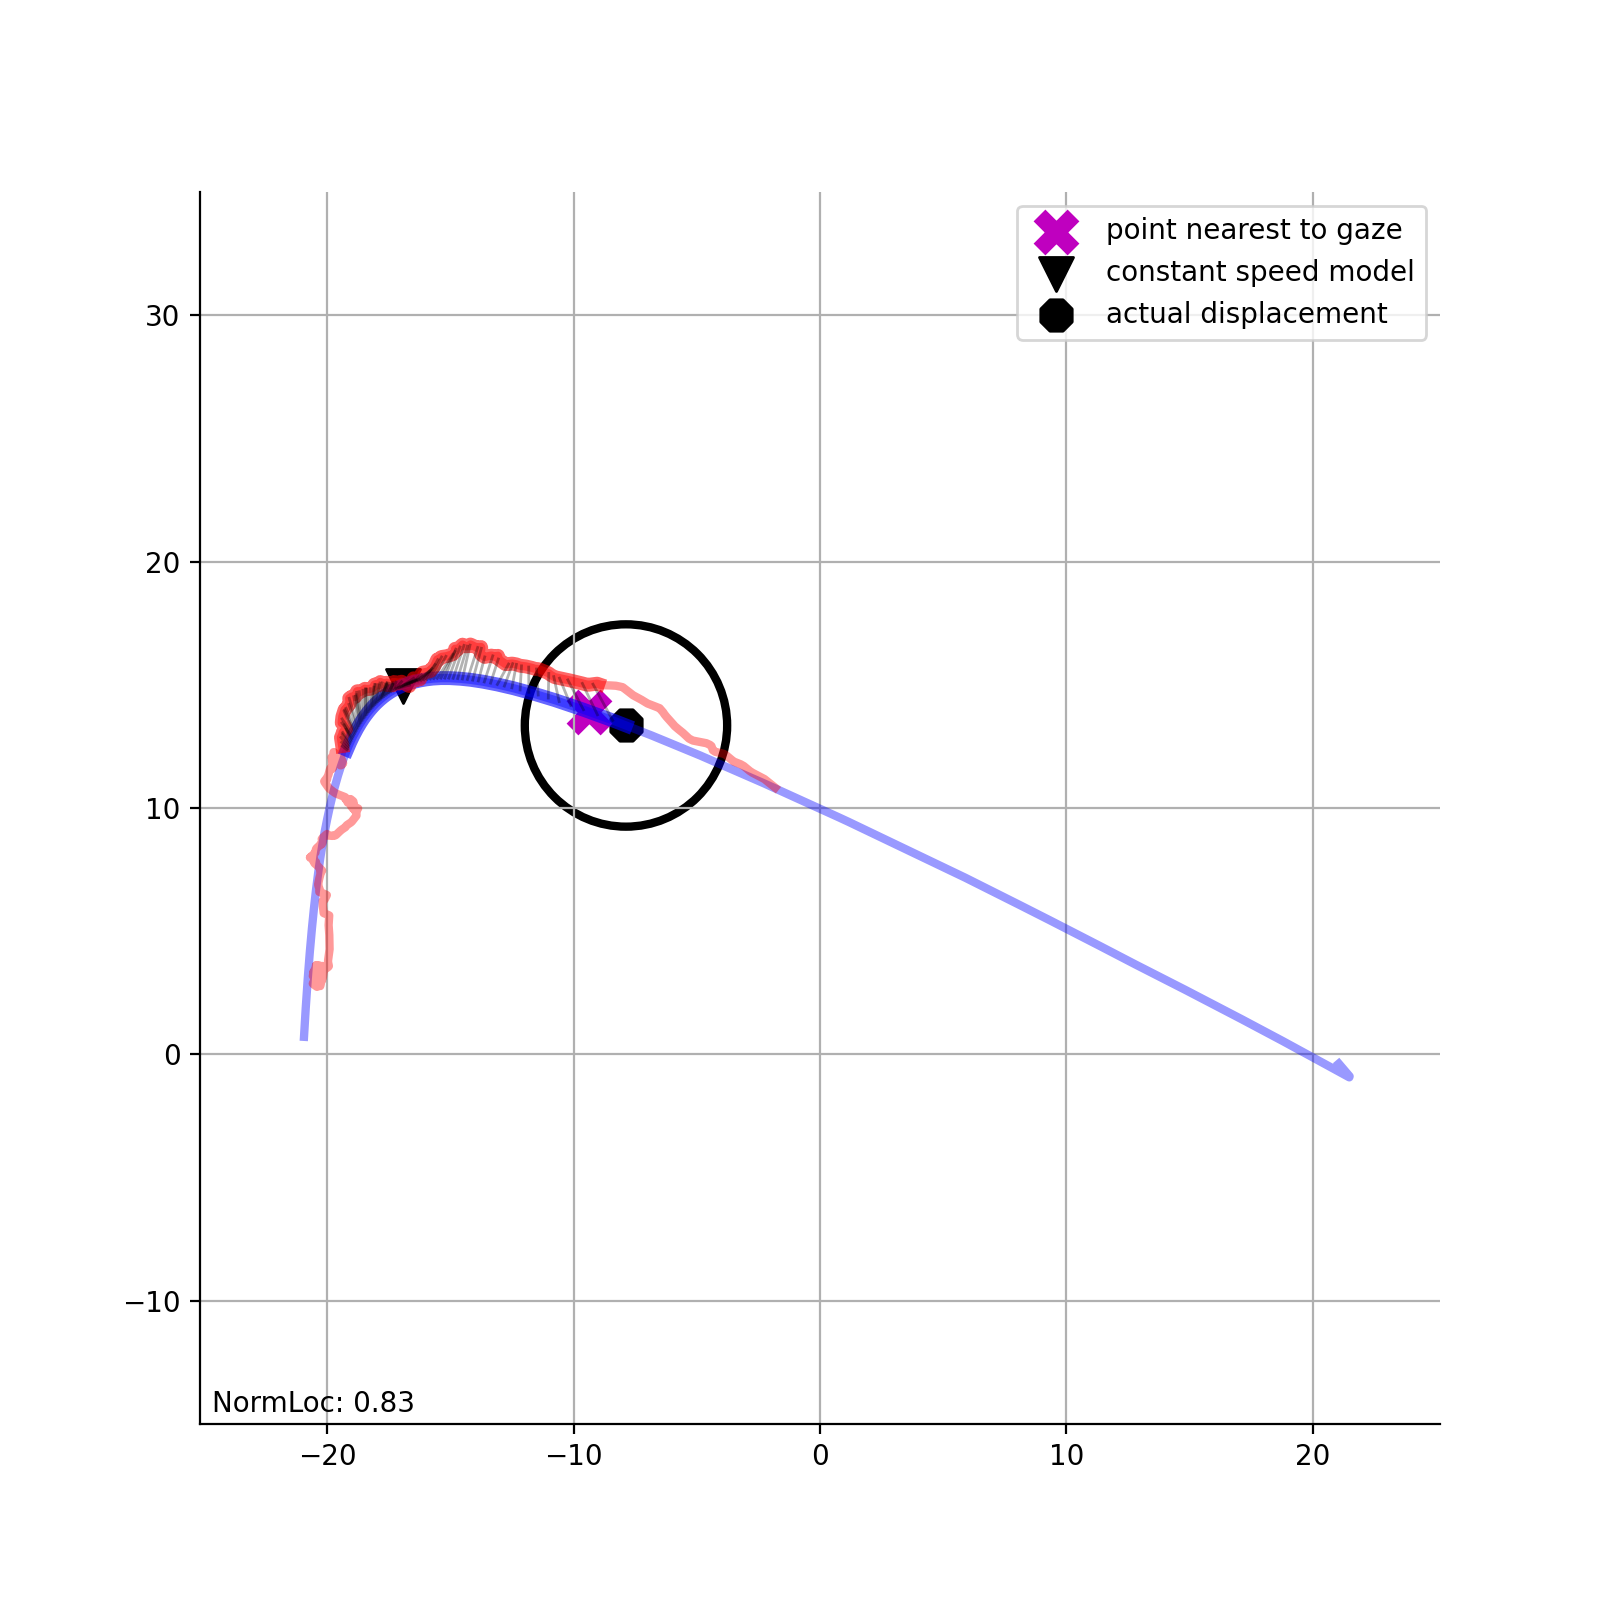

In [7]:
blNum = 2
trNumInBlock = 2

trNumAbs = list(sessionDict['trialInfo'].groupby('blockNumber').get_group(blNum)['trialNumber'])

gbData_bl_tr = sessionDict['processedExp'].groupby(['blockNumber','trialNumber']) 
gbInfo_bl_tr = sessionDict['trialInfo'].groupby(['blockNumber','trialNumber']) 

trDataGb = gbData_bl_tr.get_group( (blNum,trNumAbs[trNumInBlock]) ) 
trInfoGb = gbInfo_bl_tr.get_group( (blNum,trNumAbs[trNumInBlock]) ) 

plotProjectedTrajectory(trDataGb,trInfoGb)